# Exploratory Data Analysis (EDA)

## Imports

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from scipy.stats import norm
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET


## Dataset

### Dataset path
Indicate here the path to your dataset.

In [5]:
DATASET_PATH = '../../datasets'
SEQUENCES = [x for x in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, x))] # All sequences
# SEQUENCES = ['sequence1', 'sequence2', '...']  # Individual sequences

### Load the data (frames & labels)

In [6]:
import os
import xml.etree.ElementTree as ET
from typing import List, Dict

def load_data_grouped(DATASET_PATH: str, sequences: List[str]) -> Dict:
    """
    Carga los datos agrupados por escenario ('sala', 'hall', 'aire_libre', 'pasillo_lab'),
    sin separar por nombre de secuencia. Todos los frames de un escenario se agrupan juntos
    y se renombran de forma ascendente continua: frame_1, frame_2, ...
    """
    grouped_data = {'sala_a': {},'sala_b': {},'sala_c': {} ,'hall': {}, 'aire_libre': {}, 'pasillo_lab': {}}
    frame_counters = {'sala_a': 1, 'sala_b': 1,'sala_c': 1,'hall': 1, 'aire_libre': 1, 'pasillo_lab': 1}

    for sequence in sorted(sequences):
        # Determinar grupo
        if sequence.startswith('sala_a'):
            group = 'sala_a'
        elif sequence.startswith( 'sala_b'):
            group = 'sala_b'
        elif sequence.startswith('sala_c'):
            group = 'sala_c'
        elif sequence.startswith('hall'):
            group = 'hall'
        elif sequence.startswith('aire_libre'):
            group = 'aire_libre'
        elif sequence.startswith('pasillo_lab'):
            group = 'pasillo_lab'
        else:
            continue

        labels_path = os.path.join(DATASET_PATH, sequence, 'labels')
        if not os.path.exists(labels_path):
            continue

        # Ordenar XMLs para mantener el orden temporal
        label_files = sorted(
            [f for f in os.listdir(labels_path) if f.lower().endswith('.xml')]
        )

        for label_filename in label_files:
            label_path = os.path.join(labels_path, label_filename)
            frame_filename, bboxes = load_labels(label_path)
            frame_path = os.path.join(DATASET_PATH, sequence, 'images', frame_filename)

            new_frame_name = f"frame_{frame_counters[group]}"
            frame_counters[group] += 1

            grouped_data[group][new_frame_name] = {
                'frame_path': frame_path,
                'bboxes': bboxes,
                'source_sequence': sequence  # opcional: para saber de qué carpeta viene
            }

    return grouped_data


def load_labels(xml_file: str):
    """Carga las etiquetas y bounding boxes desde un archivo XML (formato Pascal VOC)."""
    tree = ET.parse(xml_file)
    root = tree.getroot()

    frame_filename = root.find('filename').text
    all_bboxes = []
    for obj in root.iter('object'):
        x_min = int(obj.find("bndbox/xmin").text)
        y_min = int(obj.find("bndbox/ymin").text)
        x_max = int(obj.find("bndbox/xmax").text)
        y_max = int(obj.find("bndbox/ymax").text)
        all_bboxes.append([x_min, y_min, x_max, y_max])

    return frame_filename, all_bboxes


In [7]:
SEQUENCES

['aire_libre_682',
 'aire_libre_941',
 'hall_116',
 'hall_266',
 'hall_473',
 'pasillo_lab_683',
 'pasillo_lab_961',
 'sala_a_150',
 'sala_b_540',
 'sala_b_734',
 'sala_b_775',
 'sala_c_167',
 'sala_c_250',
 'sala_c_352',
 'sala_c_452']

In [8]:
DATA = load_data_grouped(DATASET_PATH, SEQUENCES)

In [9]:
DATA

{'sala_a': {'frame_1': {'frame_path': '../../datasets\\sala_a_150\\images\\frame_0020.jpg',
   'bboxes': [[756, 327, 921, 488],
    [922, 344, 1039, 434],
    [652, 350, 676, 367],
    [678, 349, 696, 364],
    [713, 348, 727, 366]],
   'source_sequence': 'sala_a_150'},
  'frame_2': {'frame_path': '../../datasets\\sala_a_150\\images\\frame_0040.jpg',
   'bboxes': [[758, 340, 921, 494],
    [922, 337, 1049, 437],
    [651, 348, 673, 367],
    [681, 350, 701, 366],
    [717, 348, 736, 365]],
   'source_sequence': 'sala_a_150'},
  'frame_3': {'frame_path': '../../datasets\\sala_a_150\\images\\frame_0060.jpg',
   'bboxes': [[532, 339, 692, 493],
    [834, 337, 959, 443],
    [666, 350, 686, 367],
    [698, 350, 713, 366]],
   'source_sequence': 'sala_a_150'},
  'frame_4': {'frame_path': '../../datasets\\sala_a_150\\images\\frame_0080.jpg',
   'bboxes': [[543, 346, 662, 440],
    [778, 343, 869, 422],
    [660, 350, 676, 366],
    [676, 348, 689, 366]],
   'source_sequence': 'sala_a_150'},


In [7]:
DATA.keys()

dict_keys(['sala_a', 'sala_b', 'sala_c', 'hall', 'aire_libre', 'pasillo_lab'])

### Show a single frame

In [10]:
def show_frame(element: dict, alpha: int = 0.5):
    """Function that takes in a dictionary containing the data associated to an
    frame and its labels, and displays this information.

    :param element: dictionary containing the data associated to a frame and its labels.
    :param alpha: transparency value of the bboxes displayed.
    :return:
        None
    """
    # Load frame
    frame = cv2.imread(element['frame_path'])

    # Load bboxes
    bboxes = element['bboxes']

    # Overlay bboxes onto the frame
    for box in bboxes:
        
        # Initialize blank mask frame of the same dimensions for drawing the shapes
        shapes = np.zeros_like(frame, np.uint8)

        # Draw shapes
        cv2.rectangle(
            shapes,
            (box[0], box[1]),   # p1(x_min, y_min)
            (box[2], box[3]),   # p2(x_max, y_max)
            (255, 255, 255),    # color
            cv2.FILLED,
        )

        # Generate output by blending frame with shapes frame, using the shapes frames
        # also as mask to limit the blending to those parts
        mask = shapes.astype(bool)
        frame[mask] = cv2.addWeighted(frame, alpha, shapes, 1 - alpha, 0)[mask]

    # Show frame
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.imshow(frame)

In [11]:
import os
path = '../../datasets/sala_c_167/images/frame_0400.jpg'
print(os.path.exists(path))


True


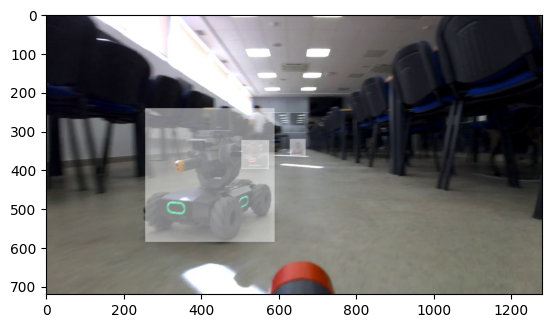

In [12]:
# Show a single frame
show_frame(DATA['sala_c']['frame_20'])

## Display frame distribution across scenarios

In [13]:
def plot_frames_distribution(data):
    """Function that takes in a dictionary containing all the information associated
    to a dataset, and displays the distribution of frames across sequences/scenarios.

    :param data: dictionary containing all the information associated to a dataset.
    :return:
        None
    """
    # Extract scenario names and their respective frame counts
    scenarios = list(data.keys())
    frame_counts = [len(data[scenario]) for scenario in scenarios]

    # Create a bar plot
    ax = plt.bar(scenarios, frame_counts, width=0.4)  # color='blue'

    # Add annotations to the bars
    for p, count in zip(ax.patches, frame_counts):
        plt.text(p.get_x() + p.get_width()/4., p.get_y() + count + 1,   # (x, y)
                 str(count),                                            # text
                 fontsize=10, fontweight='bold', color='grey')          # style

    plt.xlabel('Scenarios')
    plt.ylabel('Number of frames')
    plt.title('Distribution of frames per Scenario')
    plt.xticks(rotation=45)
    plt.ylim([0, max(frame_counts)*1.1])
    plt.tight_layout()
    # plt.savefig('frame distribution.png')
    plt.show()

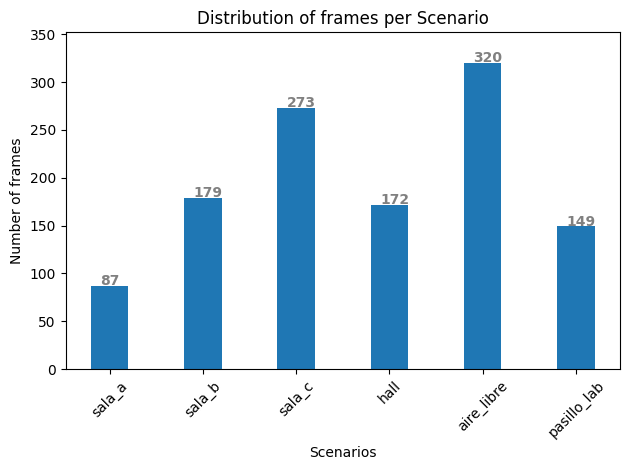

In [14]:
# Display the frame distribution for all scenarios
plot_frames_distribution(DATA)

## Display the bbox distribution across scenarios

In [15]:
def plot_bboxes_distribution(data):
    """Function that takes in a dictionary containing all the information associated
    to a dataset, and displays the distribution of bboxes across sequences/scenarios.

    :param data: dictionary containing all the information associated to a dataset.
    :return:
        None
    """
    # Extract scenario names and their respective bboxes counts
    scenarios = list(data.keys())
    bboxes_counts = []
    for scenario in scenarios:
        count = 0
        for frame in data[scenario].keys():
            count += len(data[scenario][frame]['bboxes'])
        bboxes_counts.append(count)

    # Create a bar plot
    ax = plt.bar(scenarios, bboxes_counts, width=0.4)  # color='blue'

    # Add annotations to the bars
    for p, count in zip(ax.patches, bboxes_counts):
        plt.text(p.get_x() + p.get_width()/4., p.get_y() + count + 1,   # (x, y)
                 str(count),                                            # text
                 fontsize=10, fontweight='bold', color='grey')          # style

    plt.xlabel('Scenarios')
    plt.ylabel('Number of Bboxes')
    plt.title('Distribution of Bboxes per Scenario')
    plt.xticks(rotation=45)
    plt.ylim([0, max(bboxes_counts)*1.1])
    plt.tight_layout()
    # plt.savefig('Bbox distribution.png')
    plt.show()

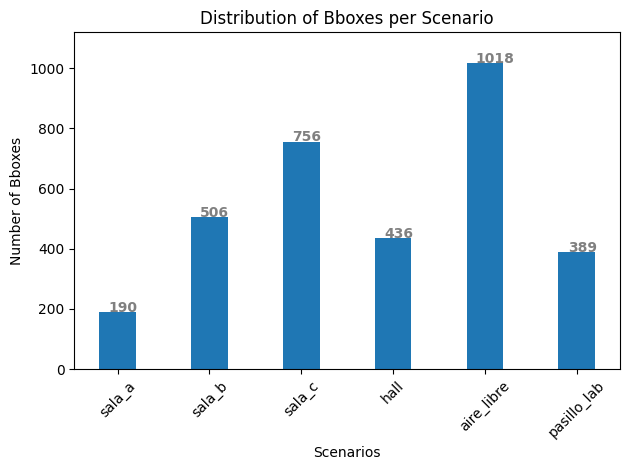

In [16]:
# Display the bbox distribution for all scenarios
plot_bboxes_distribution(DATA)

## Display the bbox area distribution across scenarios

In [17]:
def plot_bboxes_area_distribution(data: dict, bins: int = 15) -> None:
    """Function that takes in a dictionary containing all the information associated
    to a dataset, and displays the distribution of the area of bboxes across sequences/scenarios.

    :param data: dictionary containing all the information associated to a dataset.
    :param bins: number of bins to display in the histogram.
    :return:
        None
    """
    # Create a subplot with multiple histograms
    fig, axes = plt.subplots(nrows=1, ncols=len(data), figsize=(15, 5))

    # Define colors for each scenario
    colors = [
        'b', 'g', 'r', 'c', 'm',
        'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
        'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
    ]

    # Add a title above all the subplots
    plt.suptitle('Distribution of Bboxes area per Scenario')

    for i, (scenario, frame_data) in enumerate(data.items()):
        # Calculate bounding box areas for the scenario
        bbox_areas = []
        for frame_info in frame_data.values():
            for bbox in frame_info['bboxes']:
                x_min, y_min, x_max, y_max = bbox
                area = (x_max - x_min) * (y_max - y_min) / 1_000    # divide by 1_0000 for shorter x labels
                bbox_areas.append(area)

        # Plot the histogram for the scenario
        axes[i].hist(bbox_areas, bins=bins, color=colors[i], alpha=0.7)
        axes[i].set_title(scenario)
        axes[i].set_xlabel('Bounding Box Area (x1.000)')
        axes[i].set_ylabel('Frequency')

    # Adjust the layout
    plt.tight_layout()
    # plt.savefig('Bbox area distribution.png')
    plt.show()

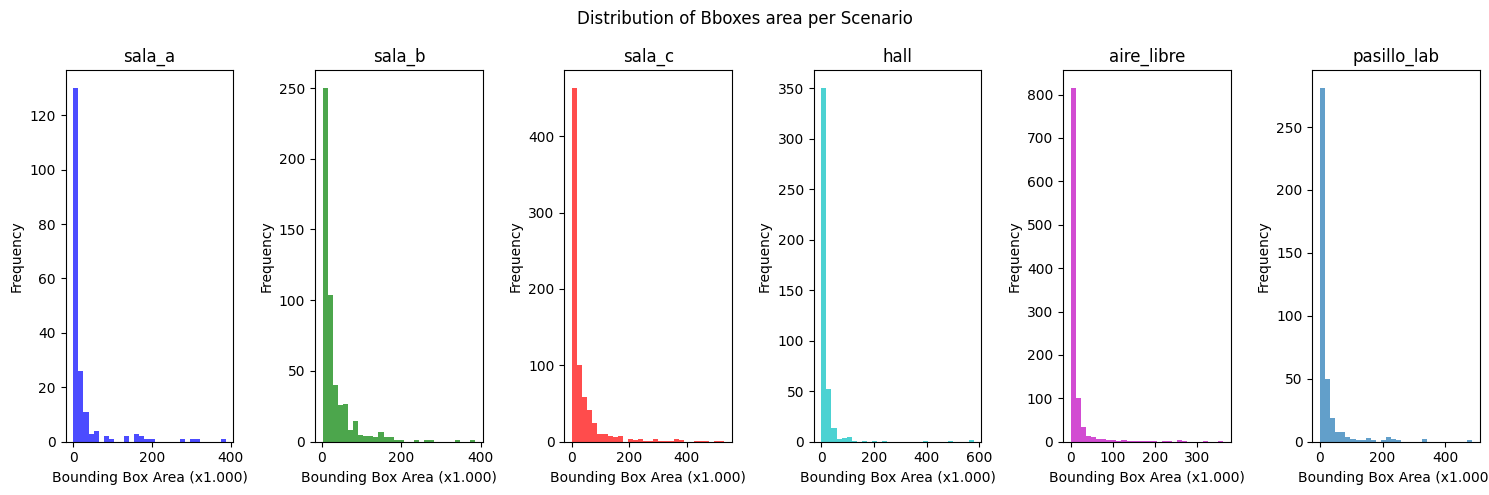

In [18]:
# Display the bbox area distribution for all scenarios
plot_bboxes_area_distribution(DATA, bins=30)

## Display the RGB channel distribution across scenarios

In [19]:
def plot_rgb_channel_distribution(data):
    """Function that takes in a dictionary containing all the information associated
    to a dataset, and displays the distribution of the RGB frame channels across sequences/scenarios.

    :param data: dictionary containing all the information associated to a dataset.
    :return:
        None
    """
    # Create a subplot with multiple Gaussian distributions
    fig, axes = plt.subplots(nrows=1, ncols=len(data), figsize=(15, 5))

    # Add a title above all the subplots
    plt.suptitle("RGB Channel Distributions (Gaussian)")

    for i, (scenario, frame_data) in enumerate(data.items()):
        red_values = []
        green_values = []
        blue_values = []

        print(f'Sequence {i+1} ({scenario}):')
        for frame_info in tqdm(frame_data.values()):
            frame_path = frame_info['frame_path']

            # Load the frame using OpenCV
            frame = cv2.imread(frame_path)

            if frame is not None:
                # Extract RGB channels
                red_channel = frame[:, :, 2].mean()
                green_channel = frame[:, :, 1].mean()
                blue_channel = frame[:, :, 0].mean()

                # Append pixel values to the respective lists
                red_values.extend([red_channel])
                green_values.extend([green_channel])
                blue_values.extend([blue_channel])

        # Compute mean and standard deviation for each channel
        red_mean, red_std = np.mean(red_values), np.std(red_values)
        green_mean, green_std = np.mean(green_values), np.std(green_values)
        blue_mean, blue_std = np.mean(blue_values), np.std(blue_values)

        # Plot Gaussian distributions for each channel
        x = np.linspace(0, 255, 256)
        red_pdf = norm.pdf(x, red_mean, red_std)
        green_pdf = norm.pdf(x, green_mean, green_std)
        blue_pdf = norm.pdf(x, blue_mean, blue_std)

        axes[i].plot(x, red_pdf, color='red', label='Red')
        axes[i].plot(x, green_pdf, color='green', label='Green')
        axes[i].plot(x, blue_pdf, color='blue', label='Blue')
        axes[i].set_title(scenario)
        axes[i].set_xlabel("Pixel Value")
        axes[i].set_ylabel("Probability Density")
        axes[i].legend()

    # Adjust the layout
    plt.tight_layout()
    # plt.savefig('frame RGB channel distribution.png')
    plt.show()

Sequence 1 (sala_a):


100%|██████████| 87/87 [00:05<00:00, 16.72it/s]


Sequence 2 (sala_b):


100%|██████████| 179/179 [00:03<00:00, 59.51it/s]


Sequence 3 (sala_c):


100%|██████████| 273/273 [00:15<00:00, 17.21it/s]


Sequence 4 (hall):


100%|██████████| 172/172 [00:01<00:00, 120.24it/s]


Sequence 5 (aire_libre):


100%|██████████| 320/320 [00:03<00:00, 99.42it/s] 


Sequence 6 (pasillo_lab):


100%|██████████| 149/149 [00:01<00:00, 121.64it/s]


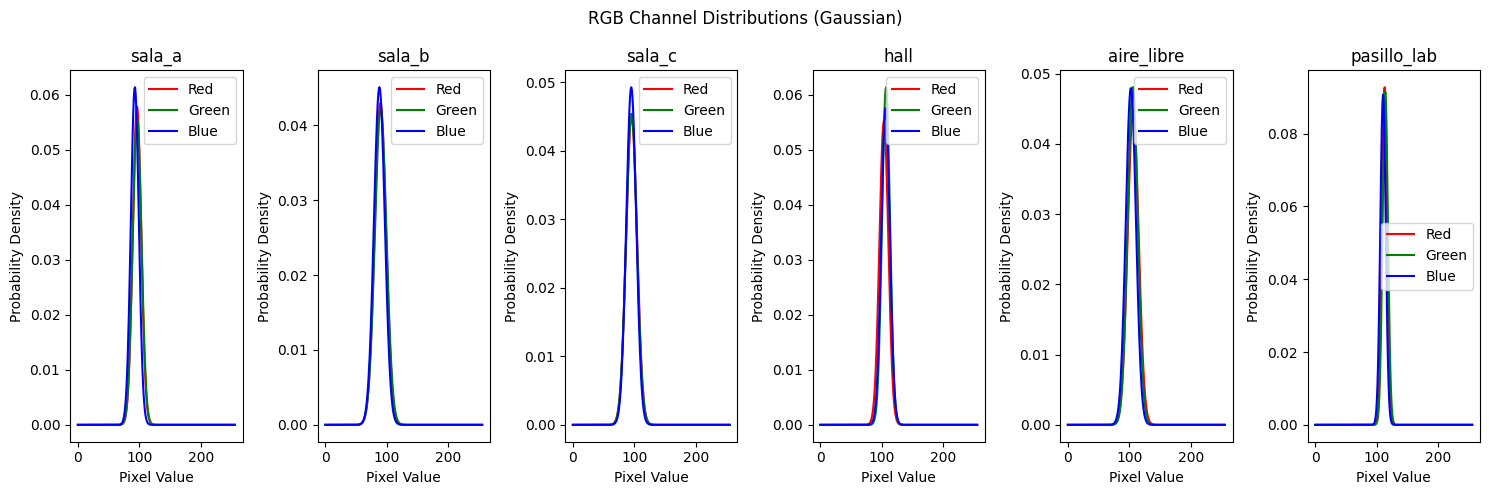

In [20]:
# Display the RGB channel distribution for all scenarios
plot_rgb_channel_distribution(DATA)

# Distribución de detecciones por escenario

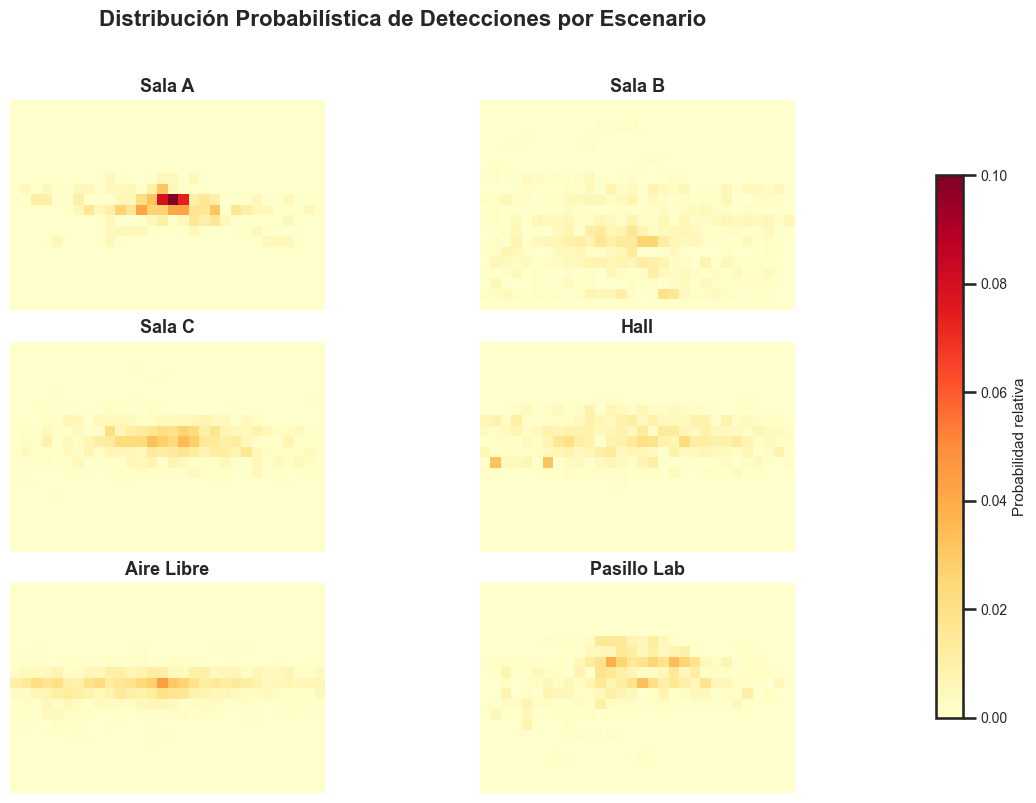

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 🎨 Estilo visual elegante
sns.set_style("white")
sns.set_context("talk", font_scale=0.9)

def plot_bbox_heatmap(scene_data, bins_x=30, bins_y=20, img_size=(1280, 720)):
    """
    Devuelve el mapa de calor NORMALIZADO (probabilidad relativa)
    de densidad de bounding boxes.
    """
    all_centers = []

    for frame_id, frame_info in scene_data.items():
        for (x1, y1, x2, y2) in frame_info['bboxes']:
            cx = (x1 + x2) / 2
            cy = (y1 + y2) / 2
            all_centers.append([cx, cy])

    if not all_centers:
        return np.zeros((bins_y, bins_x))

    centers = np.array(all_centers)
    heatmap, _, _ = np.histogram2d(
        centers[:, 0], centers[:, 1],
        bins=[bins_x, bins_y],
        range=[[0, img_size[0]], [0, img_size[1]]]
    )

    # Normalizar a probabilidad (suma total = 1)
    heatmap = heatmap / np.sum(heatmap) if np.sum(heatmap) > 0 else heatmap
    return heatmap.T


# Crear figura 3x2
fig, axes = plt.subplots(3, 2, figsize=(14, 9))
axes = axes.flatten()

# Calcular rango común
heatmaps = [plot_bbox_heatmap(DATA[e]) for e in list(DATA.keys())[:6]]
max_density = max(hm.max() for hm in heatmaps)

# Dibujar subplots
for i, (escenario, hm) in enumerate(zip(list(DATA.keys())[:6], heatmaps)):
    sns.heatmap(
        hm,
        cmap="YlOrRd",
        ax=axes[i],
        cbar=False,
        square=True,
        xticklabels=False,
        yticklabels=False,
        vmin=0,
        vmax=max_density
    )
    axes[i].set_title(escenario.replace("_", " ").title(), fontsize=13, weight="bold")
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_facecolor("white")

# Eliminar ejes vacíos si hay menos de 6
for j in range(i + 1, 6):
    fig.delaxes(axes[j])

# ✅ Crear barra de color desplazada a la derecha
norm = plt.Normalize(vmin=0, vmax=max_density)
sm = plt.cm.ScalarMappable(cmap="YlOrRd", norm=norm)
sm.set_array([])

# 🔹 Ajustar posición: más a la derecha con pad y fraction
cbar = fig.colorbar(
    sm,
    ax=axes,
    orientation="vertical",
    fraction=0.025,  # ancho más fino
    pad=0.08,        # más separación a la derecha
    anchor=(1.0, 0.5)  # centrado verticalmente
)
cbar.set_label("Probabilidad relativa", fontsize=11)
cbar.ax.tick_params(labelsize=10)

# Ajustes finales
plt.subplots_adjust(wspace=0.05, hspace=0.15, right=0.78)
fig.suptitle("Distribución Probabilística de Detecciones por Escenario", fontsize=16, weight="bold")
sns.despine(left=True, bottom=True)
plt.show()


## Robots por frame

C:\Users\juanp\AppData\Local\Temp\ipykernel_7552\2953753836.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


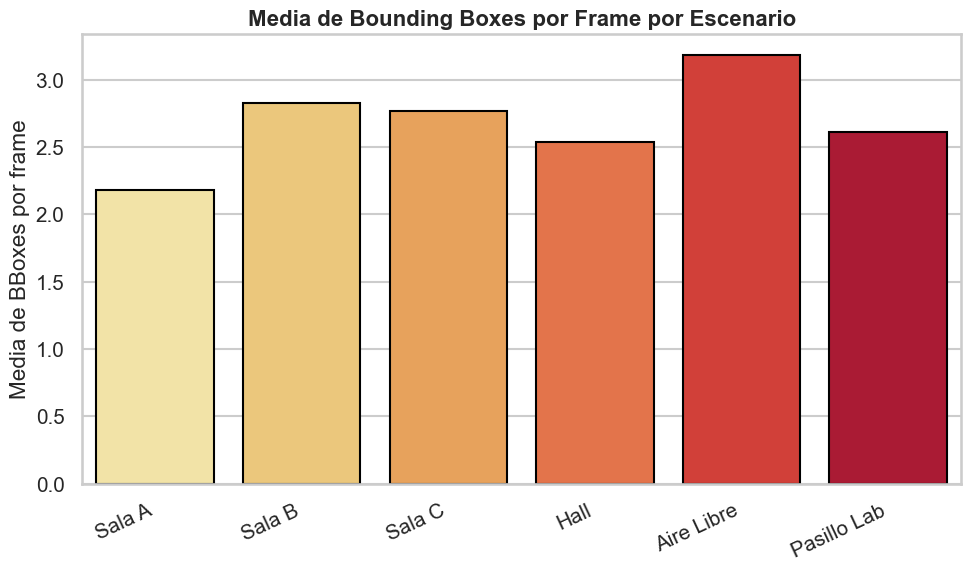

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("talk", font_scale=0.9)

def calcular_bboxes_por_frame(scene_data):
    """
    Calcula la media de número de bounding boxes por frame en un escenario.
    """
    conteos = []

    for frame_id, frame_info in scene_data.items():
        bboxes = frame_info.get("bboxes", [])
        conteos.append(len(bboxes))

    if len(conteos) == 0:
        return np.nan
    return np.mean(conteos)


# 🔹 Calcular la media de bboxes por frame para cada escenario
stats_bboxes = []
for escenario in DATA.keys():
    media_bboxes = calcular_bboxes_por_frame(DATA[escenario])
    stats_bboxes.append({
        "Escenario": escenario.replace("_", " ").title(),
        "Media de BBoxes por Frame": media_bboxes
    })

df_bboxes = pd.DataFrame(stats_bboxes).dropna()

# 🔹 Graficar resultados
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_bboxes,
    x="Escenario",
    y="Media de BBoxes por Frame",
    palette="YlOrRd",
    edgecolor="black"
)

plt.title("Media de Bounding Boxes por Frame por Escenario", fontsize=16, weight="bold")
plt.ylabel("Media de BBoxes por frame")
plt.xlabel("")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()
plt.show()

# Lapaciano de un frame para el análisis de texturas

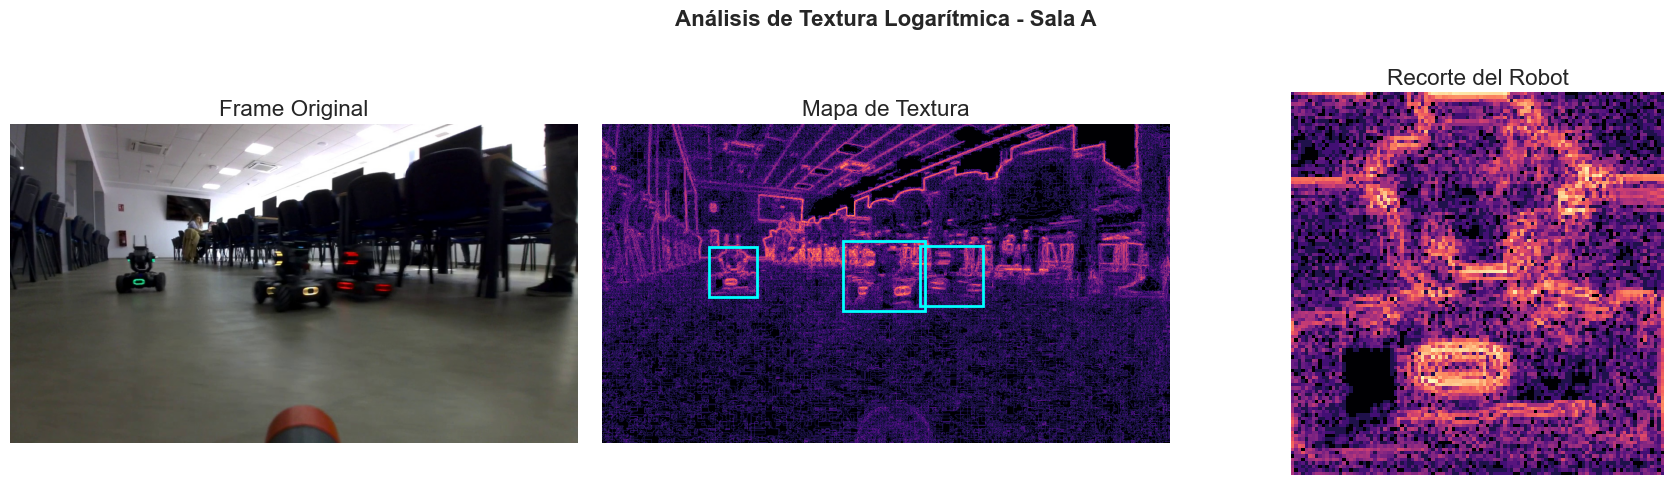

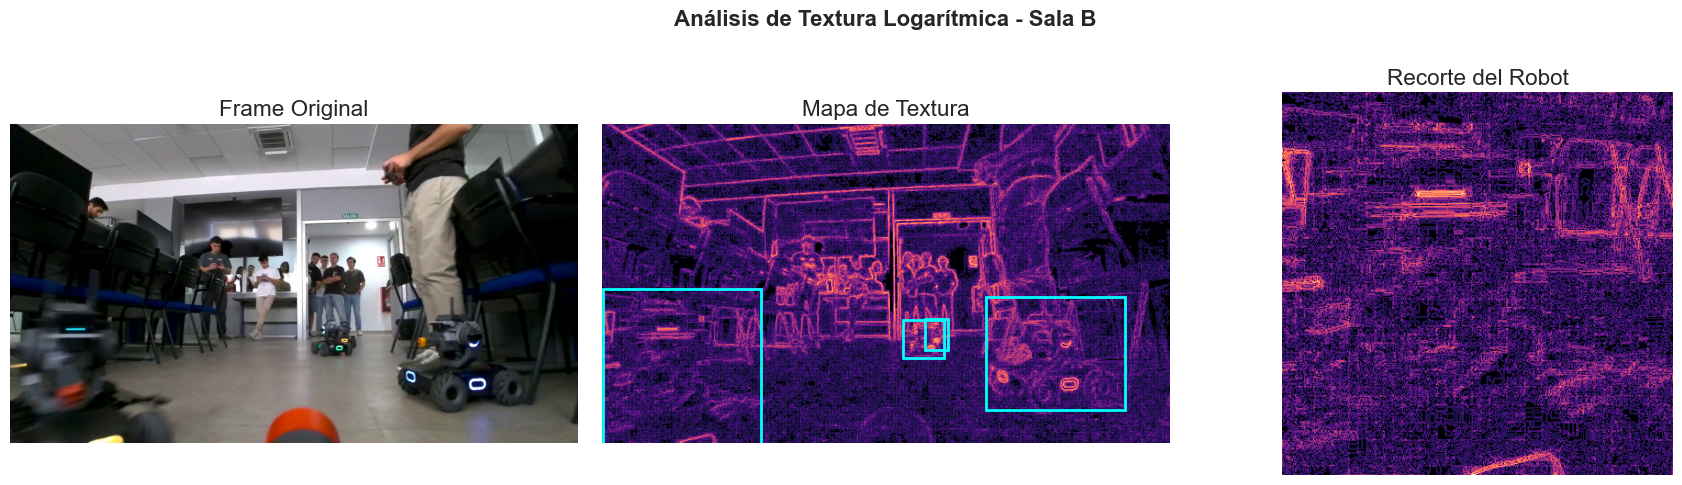

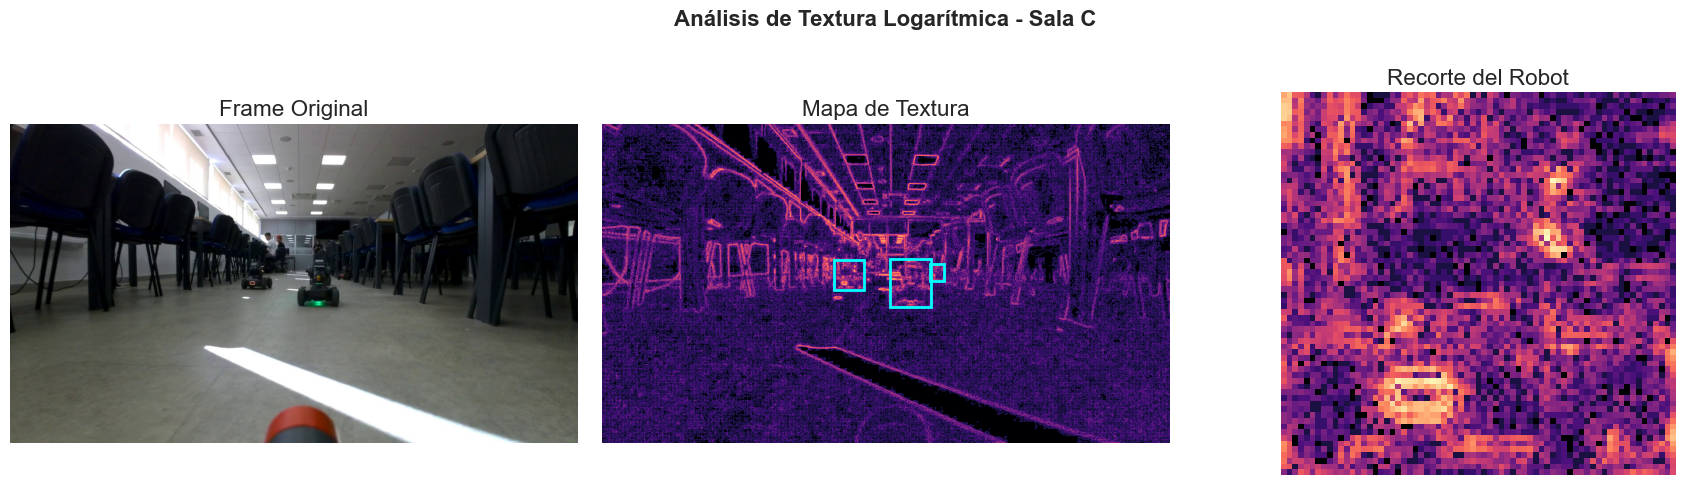

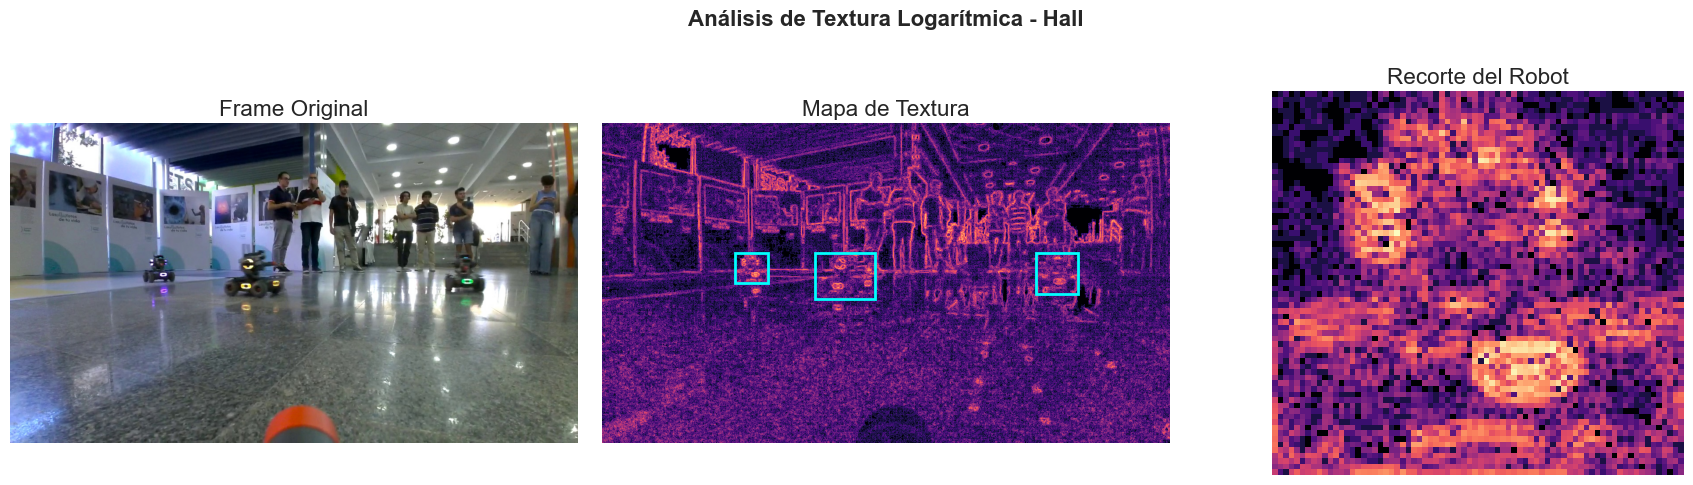

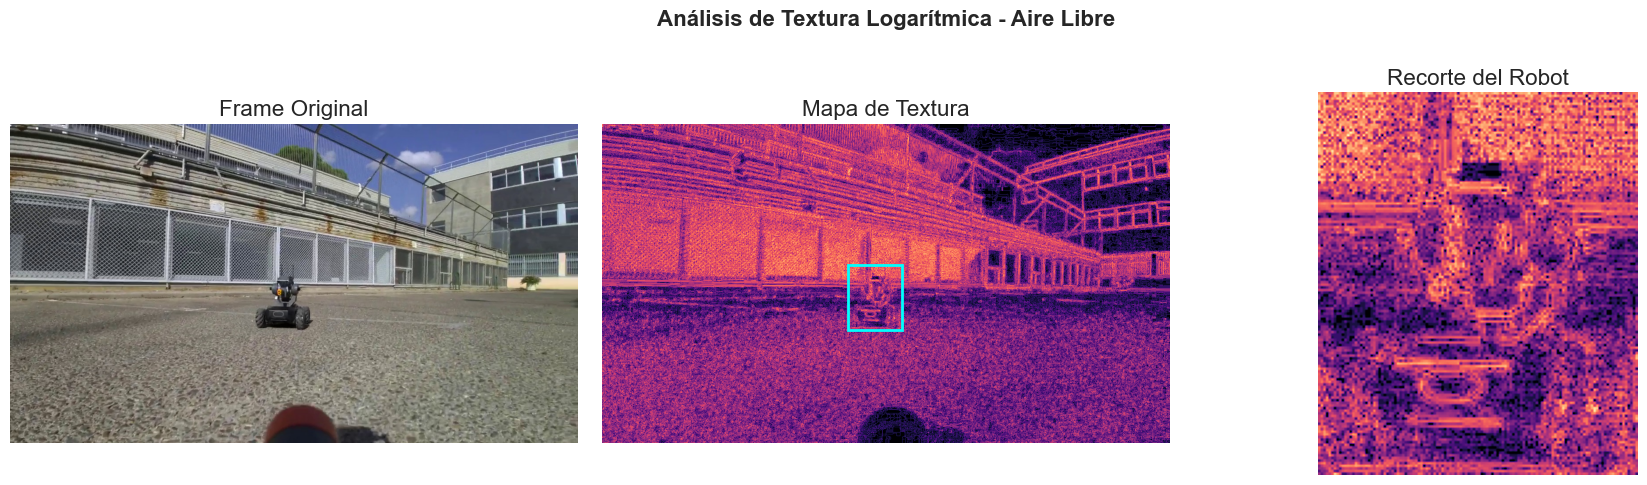

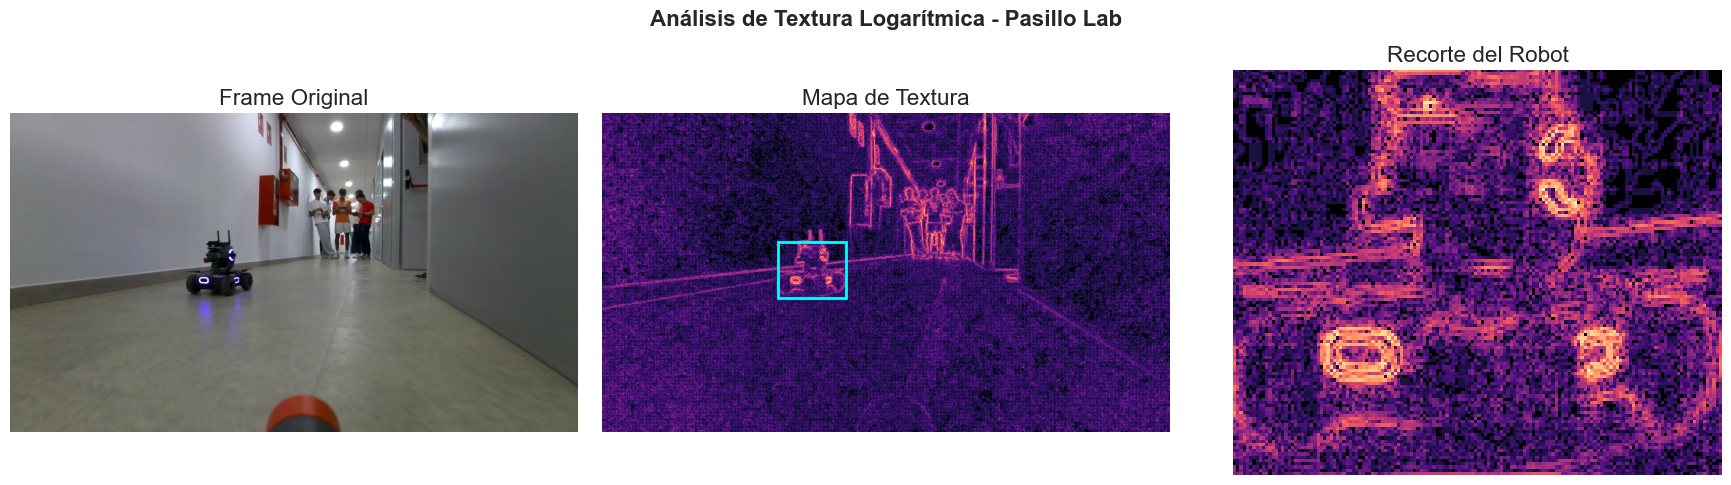

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")
sns.set_context("talk", font_scale=0.9)

def analizar_textura_frame(scene_data, frame_id=None, bbox_index=0):
    """
    Analiza la textura de un frame (Laplaciano) aplicando logaritmo
    y devuelve también el recorte del primer bounding box (robot).
    """
    # Seleccionar un frame representativo
    if frame_id is None:
        frame_id = list(scene_data.keys())[34]
    frame_info = scene_data[frame_id]
    frame_path = frame_info.get('frame_path', None)

    frame = cv2.imread(frame_path)
    if frame is None:
        print(f"[!] No se pudo cargar {frame_path}")
        return None

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Calcular textura con Laplaciano
    lap = cv2.Laplacian(gray, cv2.CV_64F)
    abs_lap = np.abs(lap)

    # Aplicar log para mejorar contraste de detalles
    log_lap = np.log1p(abs_lap)

    # Crear máscara de bounding boxes
    mask = np.zeros_like(gray, dtype=bool)
    bboxes = frame_info.get('bboxes', [])
    for (x1, y1, x2, y2) in bboxes:
        mask[int(y1):int(y2), int(x1):int(x2)] = True

    # Extraer el robot (primer bounding box)
    robot_crop = None
    if len(bboxes) > 0:
        x1, y1, x2, y2 = map(int, bboxes[bbox_index])
        robot_crop = frame[y1:y2, x1:x2]
        robot_crop_gray = cv2.cvtColor(robot_crop, cv2.COLOR_BGR2GRAY)
        robot_crop_lap = np.abs(cv2.Laplacian(robot_crop_gray, cv2.CV_64F))
        log_robot_crop_lab = np.log1p(robot_crop_lap) 
        
    return {
        "frame": frame,
        "log_lap": log_lap,
        "mask": mask,
        "robot_crop": log_robot_crop_lab
    }


# 🔹 Analizar un frame por escenario
for escenario in list(DATA.keys())[:6]:
    resultado = analizar_textura_frame(DATA[escenario])
    if resultado is None:
        continue

    frame = resultado["frame"]
    log_lap = resultado["log_lap"]
    mask = resultado["mask"]
    robot_crop = resultado["robot_crop"]

    # Crear figura con 3 visualizaciones
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"Análisis de Textura Logarítmica - {escenario.replace('_',' ').title()}",
                 fontsize=16, weight="bold")

    axs[0].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Frame Original")
    axs[0].axis("off")

    axs[1].imshow(log_lap, cmap="magma")
    axs[1].set_title("Mapa de Textura")
    axs[1].axis("off")

    for (x1, y1, x2, y2) in DATA[escenario][list(DATA[escenario].keys())[34]]["bboxes"]:
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, edgecolor="cyan", facecolor="none", lw=2)
        axs[1].add_patch(rect)

    if robot_crop is not None and robot_crop.size > 0:
        axs[2].imshow(robot_crop, cmap="magma")
        axs[2].set_title("Recorte del Robot")
        axs[2].axis("off")
    else:
        axs[2].imshow(np.zeros((100, 100, 3), dtype=np.uint8))
        axs[2].set_title("Sin Bounding Box")
        axs[2].axis("off")

    plt.tight_layout()
    plt.show()


100%|██████████| 6/6 [07:18<00:00, 73.05s/it]


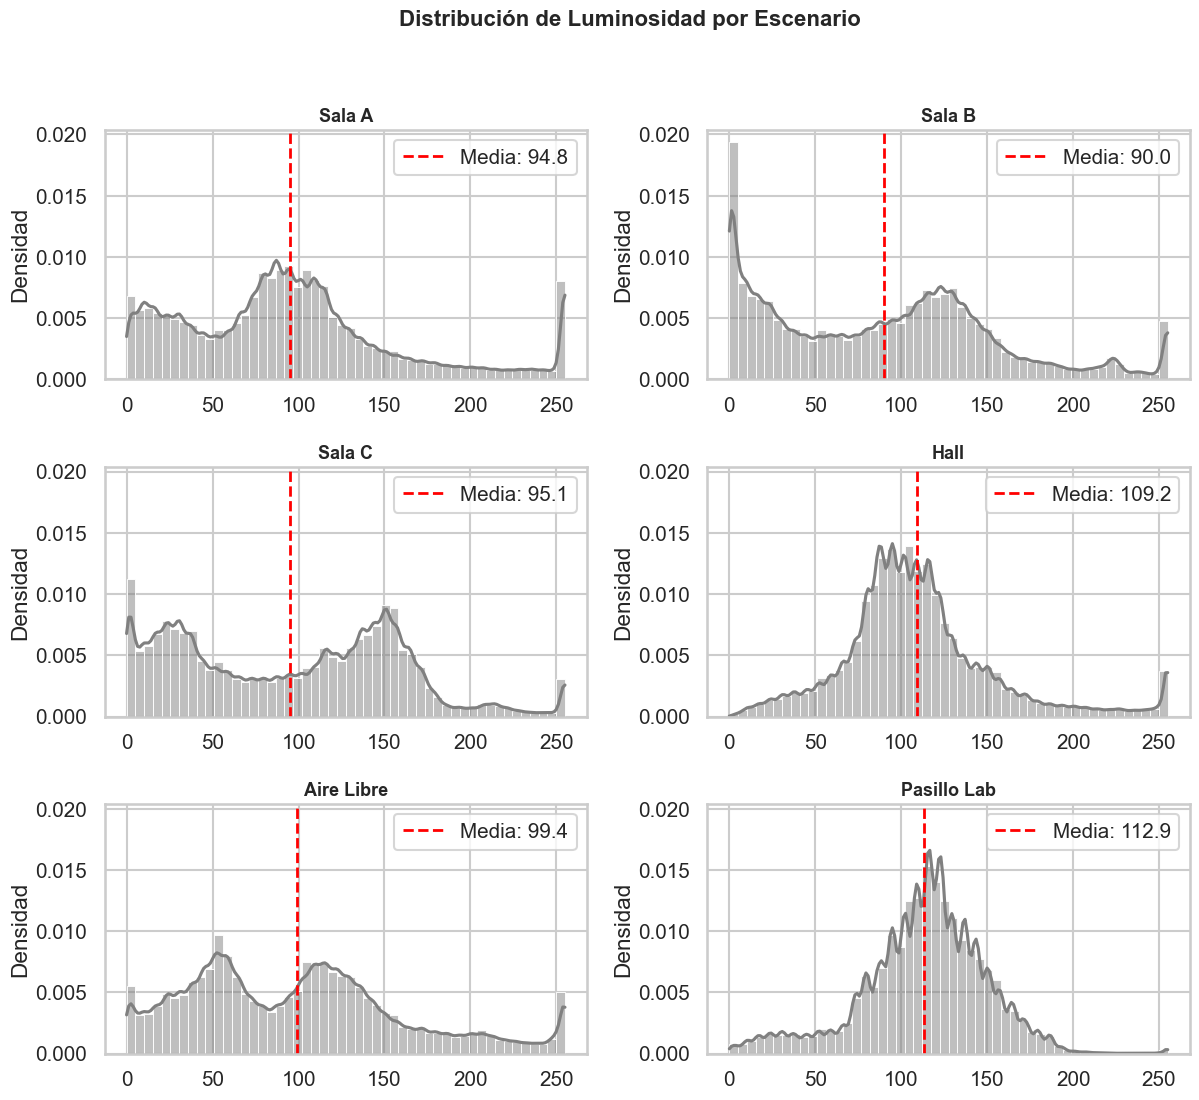

In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("talk", font_scale=0.9)

def obtener_luminosidades(scene_data, sample_frames=20):
    """
    Devuelve una lista con todos los valores de luminosidad (0–255)
    de varios frames en un escenario.
    """
    valores = []
    frame_ids = list(scene_data.keys())[:sample_frames]

    for frame_id in frame_ids:
        frame_info = scene_data[frame_id]
        frame_path = frame_info.get("frame_path", None)
        if frame_path is None:
            continue

        frame = cv2.imread(frame_path)
        if frame is None:
            continue

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        valores.extend(gray.ravel())  # añadir todos los píxeles

    return np.array(valores)


# 🔹 Configurar figura
num_escenarios = len(DATA.keys())
cols = 2
rows = int(np.ceil(num_escenarios / cols))

fig, axes = plt.subplots(rows, cols, figsize=(14, rows * 4))
axes = axes.flatten()

# Calcular el mismo rango del eje Y para todos
max_density = 0
luminosidades = {}

for escenario in DATA.keys():
    valores = obtener_luminosidades(DATA[escenario], sample_frames=20)
    if len(valores) == 0:
        continue
    luminosidades[escenario] = valores
    counts, _ = np.histogram(valores, bins=50, range=(0, 255), density=True)
    max_density = max(max_density, counts.max())

# Dibujar cada histograma
for i, escenario in enumerate(tqdm(DATA.keys())):
    if escenario not in luminosidades:
        continue
    valores = luminosidades[escenario]

    sns.histplot(
        valores,
        bins=50,
        kde=True,
        color="gray",
        ax=axes[i],
        stat="density"
    )

    axes[i].set_title(f"{escenario.replace('_', ' ').title()}",
                      fontsize=13, weight="bold")
    axes[i].set_xlabel("")  # quitar texto de eje X
    axes[i].set_ylabel("Densidad")

    # Añadir línea de media
    mean_val = np.mean(valores)
    axes[i].axvline(mean_val, color="red", linestyle="--", lw=2, label=f"Media: {mean_val:.1f}")
    axes[i].legend()

    # Fijar el mismo rango de Y
    axes[i].set_ylim(0, max_density * 1.05)

# Eliminar ejes vacíos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Ajustar espaciamiento y título
fig.suptitle("Distribución de Luminosidad por Escenario", fontsize=16, weight="bold")
plt.subplots_adjust(wspace=0.25, hspace=0.35)
plt.show()
